Few key observations
- If both and non-encrypted files are base-32 encoded, accuracy drops really low.
   * Even in this case, fourier analysis (specifically autocorrelation and mean) provide good discrminators
   * Renyi's entropy at alpha=infinity gives good discrimination
   * Overall we see around 13% improvement in F1-score
- Specifically for webpfiles
   * We see that higher moments of around 14 gives a good discrimination
   * Fourier analysis still gives benefits here
- For webpfiles where both unencrypted and encrypted content are base32 encrypted
   * Fourier analysis is still beneficial
- For Non-webp files where plaintext is not base-32 encrypted
   * Accuracy is decent with just the base parameters, but with fourier analysis, we can close to perfect detection


## Implementation <a class="anchor" id="implementation">
    
[top](#Contents)

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

from functools import lru_cache

import gc

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, accuracy_score, recall_score

import matplotlib.pyplot as plt
import glob

import tqdm
from multiprocessing.pool import ThreadPool, Pool

plt.rcParams["figure.figsize"] = (20,20)

### List of files <a class="anchor" id="list-of-files">

[top](#Contents)

In [2]:
!ls

Iteration_2.1_EXT2_RF_weighted_importances.ipynb
expanded.plaintext.base32.csv.gz
expanded.pyencrypted_v1.b32.csv.gz
expanded.pyencrypted_v1.csv.gz
expanded.pyencrypted_v2.base32.csv.gz
expanded.pyencrypted_v2.csv.gz
iteration_2.1_compare_base32_alternate_encryption_scheme.ipynb
iteration_2.1_compare_base32_logistic_regression.ipynb
plaintext.base32.combined.csv.gz
plaintext.combined.csv.gz
plaintext.expanded.csv.gz


### Utility utilities<a class="anchor" id="gc">
    
[top](#Contents)

In [3]:
def call_gc():
    for i in range(3):
        for j in range(3):
            gc.collect(j)
            
import pickle
def save_results(filename, column, all_results):
    save_tuple = (column, all_results,)
    with open(filename, "wb") as f:
        pickle.dump(save_tuple, f, pickle.HIGHEST_PROTOCOL)

### Selection of columns <a class="anchor" id="select-columns">
    
This function is used to select the columns.
There are three different configurations:
    
    1. Baseline - statistics like autocorrelation, shannon entropy, chi-square etc. are used
    
    2. Advanced - More statistics like moments, Tsallis and Renyi entropy, higher moments etc.
    
    3. Fourier - Some statistics of the Fourier Power Spectrum distribution
    
[top](#Contents)

In [4]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))
    
    return {\
        "fourier": fourier_columns,\
    }

### Function to compare the three selections of columns for a given dataset <a class="anchor" id="compare-fn">
    
For the three different sets of measurements described above, compare all the three sets for their f1 score
    
[top](#Contents)

In [5]:
USE_ASYNC = False
N_SPLITS=5

def get_weighted_feature_importances_inloop(f1_scores, feature_importances):
    """
    First scale the importances so that the column with the maximum
    importance has an importance 1.
    
    Next find the weighted mean w.r.t. the f1-score
    """
    out_importances = np.zeros(len(feature_importances[0]))
    for f1, importance in zip(f1_scores, feature_importances):
        importance = importance / np.max(importance)
        importance = importance * f1
        out_importances = out_importances + importance
    out_importances /= sum(f1_scores)
    return out_importances

def get_kfold_f1_score(name, collist, X, y):
    skf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    feature_importances = []
    X = X[collist].to_numpy()
    y = y.to_numpy()
    call_gc()
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        rfc = RandomForestClassifier(n_jobs=10, random_state=42)
        estimators = [\
                      ('std,', MinMaxScaler()), \
                      ('RandomForestClassifier', rfc)]
        pipeline = Pipeline(estimators)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        feature_importances.append(rfc.feature_importances_)

    return name, \
            float(np.mean(f1_scores)),\
            float(np.mean(accuracy_scores)),\
            float(np.mean(precision_scores)),\
            float(np.mean(recall_scores)),\
            get_weighted_feature_importances_inloop(f1_scores, feature_importances)
            

def compare_feature_selections_async(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    pool = Pool(3)
    async_results = list()
    for name, collist in columns_dict.items():
        result = pool.apply_async(\
                                  get_kfold_f1_score, \
                                  (name, collist, X, y))
    for result in async_results:
        name, f1 = result.get(timeout=None)
        ret[name] = f1
    return ret

def compare_feature_selections_sync(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    for name, collist in columns_dict.items():
        name, f1, accuracy, precision, recall, fimp = \
            get_kfold_f1_score(name, collist, X, y)
        ret[f"{name}-f1_score"] = f1
        ret[f"{name}-accuracy_score"] = accuracy
        ret[f"{name}-precision_score"] = precision
        ret[f"{name}-recall_score"] = recall
        ret[f"{name}-feature_importances"] = fimp
    return ret

def compare_feature_selections(X, y):
    if USE_ASYNC:
        return compare_feature_selections_async(X, y)
    else:
        return compare_feature_selections_sync(X, y)

def compare_feature_selections_wrapper(data):
    X = data[[c for c in data.columns if "is_encrypted" != c]]
    y = data["is_encrypted"]
    return compare_feature_selections(X, y)


### Load the datasets <a class="anchor" id="load-dataset">

We don't want to load the datasets again and again, so we load them once.
The LRU cache ensures that the next time this is called, we don't load the datasets again.
    
[top](#Contents)

In [6]:
@lru_cache
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("*.csv.gz"):
        df = pd.read_csv(file)
        df = df.sample(frac=1).reset_index(drop=True)
        df["is_encrypted"] = 1 if "encr" in file.lower() else 0
        datasets[file] = df
    return datasets

### Select the datasets <a class="anchor" id="dataset-selection">

Select the dataset, combine it, shuffle it and return
    
We used several schemes:
* Plaintext
  - The base plaintext dataset of around 50k files
  - Expanded dataset, where all files that were less than 1500 bytes were expanded by repeating the file
  - Base32 encoding of
   - original plaintext
   - expanded plaintext
* Encryption : We used two schemes for encruption
  - v1 : AES 256 encryption of the full file, again two varieties were used
    - Plain encryption
    - Encryption followed by base32 encoding
  - v2 : AES encryption of the file, the first and the last 128 bytes are not encrypted. Of the remaining file, every alternate 16 bytes are encrypted.
    - Plain encryption
    - encryption followed by base32 encoding
    
We select combinations of the above datasets
    
Furthermore, we add further combinations by including and excluding webp files, and including and excluding non-webp files.
    
[top](#Contents)

In [7]:
def get_dataset(\
               exclude_plaintext_nonbase32=False,
               exclude_plaintext_base32=False,
               exclude_encrypted_v1=False,
               exclude_encrypted_v2=False,
               exclude_encrypted_base32=False,
               exclude_encrypted_nonbase32=False,
               exclude_webp=False,
               exclude_nonwebp=False):
    description = {k:v for k,v in locals().items() \
                   if "exclude" in k}
    
    files = glob.glob("*.csv.gz")
    
    
    if exclude_plaintext_nonbase32:
        files = [f for f in files if \
                     "plaintext" not in f \
                     or "_base32" in f \
                     or "_b32" in f]
    if exclude_plaintext_base32:
        files = [f for f in files if\
                    "plaintext" not in f or \
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_v1:
        files = [f for f in files if\
                    "_v1" not in f or "encr" not in f]
    if exclude_encrypted_v2:
        files = [f for f in files if \
                    "_v2" not in f or "encr" not in f]
    if exclude_encrypted_base32:
        files = [ f for f in files if\
                    "encr" not in f or\
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_nonbase32:
        files = [f for f in files if \
                    "encr" not in f or \
                    "base32" in f or "b32" in f]
        
        
    encrypted_count = len([f for f in files if "encr" in f])
    non_encrypted_count = len([f for f in files if "encr" not in f])
    
    if 0 == encrypted_count or 0 == non_encrypted_count or 0 == len(files):
        return description, None, -1, -1
    
    all_dfs = list()
    all_loaded_datasets = load_datasets_once()
    for filename in files:
        all_dfs.append(all_loaded_datasets[filename])
    
    combined_df = pd.concat(all_dfs)
    
    if exclude_webp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] != ".webp"]
    if exclude_nonwebp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] == ".webp"]
        
    if len(combined_df) == 0:
        return description, None, -1, -1
    
        
    encrypt_count = len(combined_df[combined_df["is_encrypted"] == 1])
    nonencrypted_count = len(combined_df[combined_df["is_encrypted"] == 0])

    
    if 0 == len(combined_df) or 0 == encrypt_count or 0 == nonencrypted_count:
        return description, None, -1, -1
    
    return description, combined_df, encrypt_count, nonencrypted_count

### Run all combinations of data <a class="anchor" id="dataset-selection">

For all combinations of the datasets, compare the three classes (basic, advanced, and Fourier)
    
[top](#Contents)

In [8]:
all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0] if "feature_importance" not in k}
for result in all_results:
    for k, v in result.items():
        if "feature_importances" not in k:
            df_dict[k].append(v)


def get_weighted_importances_1(all_results):
    f1_colname = None
    importance_colname = None
    for k in all_results[0]:
        if "f1_score" in k:
            f1_colname = k
        if "feature_importance" in k:
            importance_colname = k
    f1_scores = []
    importances = []
    print(f1_colname, importance_colname)
    for result in all_results:
        f1_scores.append(result[f1_colname])
        importances.append(result[importance_colname])
    
    out_importances = np.zeros(len(importances[0]))
    for f1, imp in zip(f1_scores, importances):
        out_importances = out_importances + imp * f1
    out_importances = out_importances / sum(f1_scores)
    
    return out_importances

print(get_weighted_importances_1(all_results))



100%|██████████████████████████████████████████████████| 256/256 [1:24:17<00:00, 19.76s/it]

fourier-f1_score fourier-feature_importances
[2.53872270e-01 2.04529740e-01 1.42633708e-02 1.72702287e-01
 6.01838623e-02 3.45105349e-01 1.00941474e-01 2.91453661e-02
 5.84821008e-01 2.33023112e-01 6.75359325e-01 2.48101580e-01
 7.56366644e-02 1.96555092e-01 7.42316087e-04 1.62869961e-01
 2.40627182e-01 4.10942089e-01 1.89036390e-03 2.63814445e-05
 2.56802876e-01 7.18733212e-02 3.09596264e-01 7.10612225e-02
 3.96527826e-01 2.35567637e-01 3.02194251e-02 5.38029624e-05
 4.59270046e-01 5.91827863e-05 6.46858827e-04 1.65146884e-01
 1.60682268e-01 2.84900490e-01 1.60565636e-01 2.14267401e-01
 3.65959420e-01 6.06608564e-06 6.56840848e-02 1.90453658e-04
 8.04698781e-02 7.69614022e-03 5.20769111e-02 6.12361812e-04
 2.92370628e-03 3.31576487e-01 1.02283566e-01 2.98963855e-01
 7.49243628e-03 2.62615940e-01 2.20716291e-01 2.23427031e-01
 3.05135554e-02 5.54377601e-06 2.74457251e-01 1.56723135e-01
 3.12118880e-01 4.10018191e-01 2.85495966e-01 1.96573202e-01
 2.46801268e-01 1.13016546e-03 2.5970806

In [9]:
columns = get_columns(df[[c for c in df.columns if "is_encrypted" != c]])["fourier"]

save_results("weighted-scaled-results.pickle", columns, all_results)

fourier-f1_score fourier-feature_importances


<AxesSubplot:xlabel='importances', ylabel='features'>

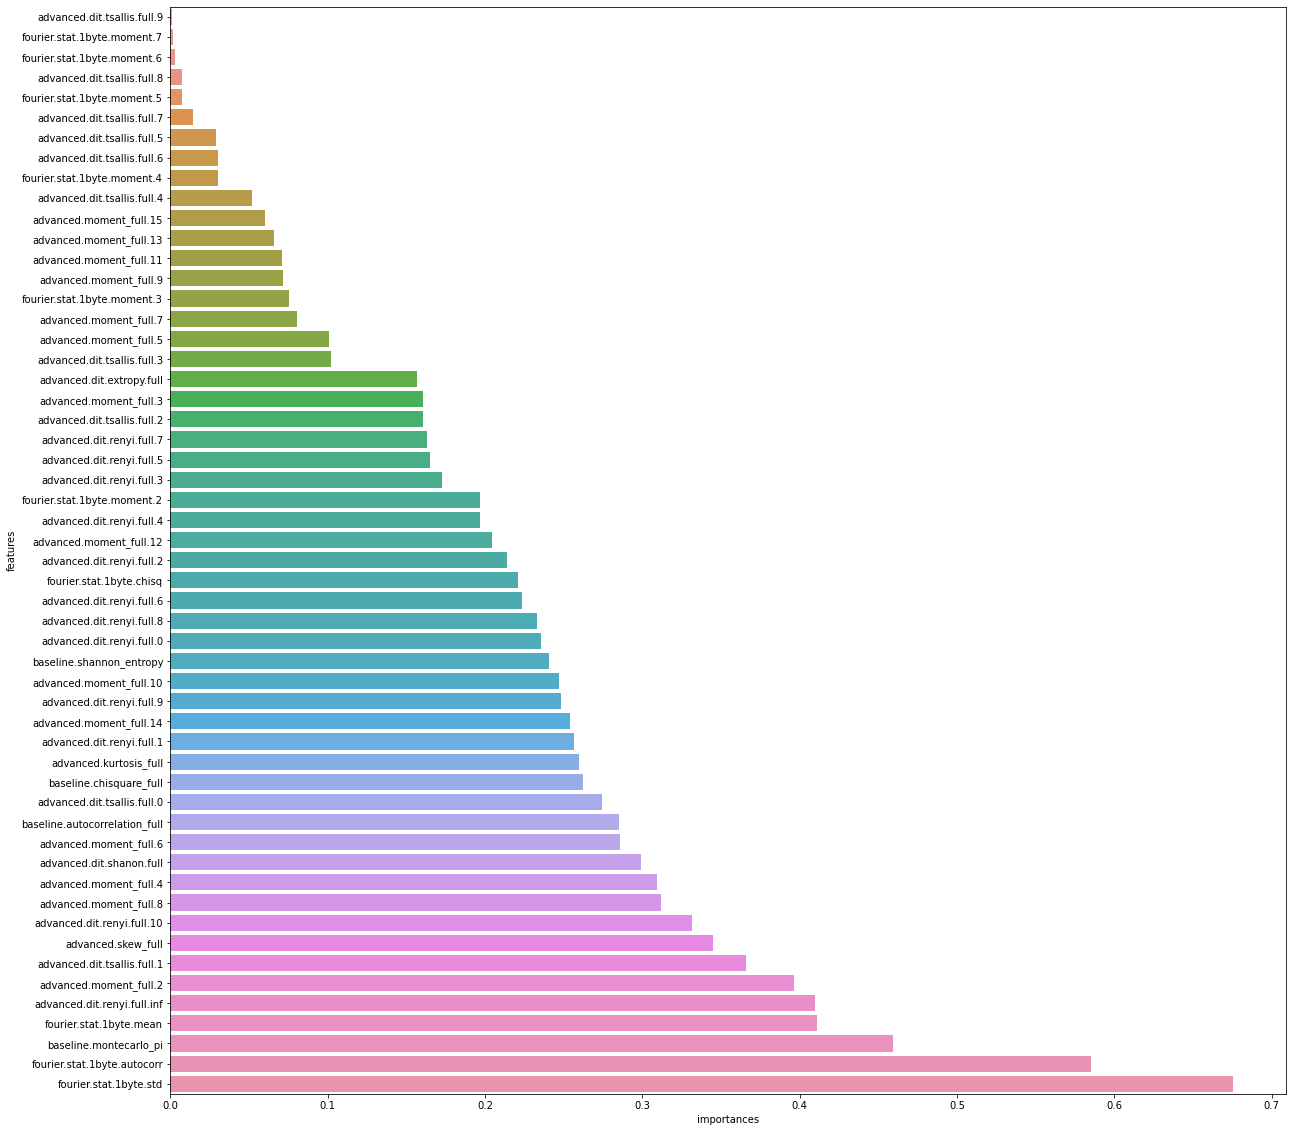

In [11]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,20)



df2_dict = {"features": columns, "importances": get_weighted_importances_1(all_results)}
imp_df = pd.DataFrame(df2_dict)
imp_df = imp_df.sort_values(by="importances", ascending=True).reset_index(drop="True")
imp_df = imp_df[imp_df["importances"] > 0.001]
sns.barplot(y="features", x="importances", data=imp_df)

### Somewhat different weighted calculation

In the earlier weighted calculation, we had scaled each importance matrix
before calculating the weighted average.
in this one, we don't.


In [12]:
# Redefining this
####
def get_weighted_feature_importances_inloop(f1_scores, feature_importances):
    """
    Redefined function
    
    Next find the weighted mean w.r.t. the f1-score
    """
    out_importances = np.zeros(len(feature_importances[0]))
    for f1, importance in zip(f1_scores, feature_importances):
        # importance = importance / np.max(importance)
        importance = importance * f1
        out_importances = out_importances + importance
    out_importances /= sum(f1_scores)
    return out_importances

all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0] if "feature_importance" not in k}
for result in all_results:
    for k, v in result.items():
        if "feature_importances" not in k:
            df_dict[k].append(v)


def get_weighted_importances_1(all_results):
    f1_colname = None
    importance_colname = None
    for k in all_results[0]:
        if "f1_score" in k:
            f1_colname = k
        if "feature_importance" in k:
            importance_colname = k
    f1_scores = []
    importances = []
    print(f1_colname, importance_colname)
    for result in all_results:
        f1_scores.append(result[f1_colname])
        importances.append(result[importance_colname])
    
    out_importances = np.zeros(len(importances[0]))
    for f1, imp in zip(f1_scores, importances):
        out_importances = out_importances + imp * f1
    out_importances = out_importances / sum(f1_scores)
    
    return out_importances

print(get_weighted_importances_1(all_results))


plt.rcParams["figure.figsize"] = (20,20)

columns = get_columns(df[[c for c in df.columns if "is_encrypted" != c]])["fourier"]



100%|██████████████████████████████████████████████████| 256/256 [1:21:51<00:00, 19.19s/it]


fourier-f1_score fourier-feature_importances
[2.24209511e-02 1.73964606e-02 1.04098667e-03 1.47255894e-02
 4.79038133e-03 3.31832858e-02 8.10587962e-03 2.03511196e-03
 5.47986923e-02 1.94162522e-02 7.31901576e-02 2.07945160e-02
 7.04616416e-03 1.86217754e-02 5.59707939e-05 1.34677530e-02
 2.11675126e-02 4.00587263e-02 1.44529807e-04 1.57024479e-06
 2.34371907e-02 5.93573630e-03 2.83970074e-02 5.89705956e-03
 3.79218143e-02 2.56224256e-02 2.34270367e-03 3.74697416e-06
 4.52092547e-02 3.93118828e-06 4.74080064e-05 1.38977633e-02
 1.35513404e-02 2.48803793e-02 1.25110712e-02 1.87816320e-02
 3.42388983e-02 3.93177224e-07 5.37966955e-03 1.33501399e-05
 6.60854356e-03 6.05569408e-04 4.15186575e-03 4.96256697e-05
 2.10924249e-04 2.82194992e-02 8.62442442e-03 2.74219396e-02
 5.44560902e-04 2.03186647e-02 1.97688245e-02 1.88746736e-02
 2.61100889e-03 3.58503761e-07 2.98880450e-02 1.32498868e-02
 2.80183315e-02 3.24792981e-02 2.63888689e-02 1.70059477e-02
 2.12782642e-02 8.70496721e-05 2.3058782

In [13]:
save_results("weighted-results.pickle", columns, all_results)

fourier-f1_score fourier-feature_importances


<AxesSubplot:xlabel='importances', ylabel='features'>

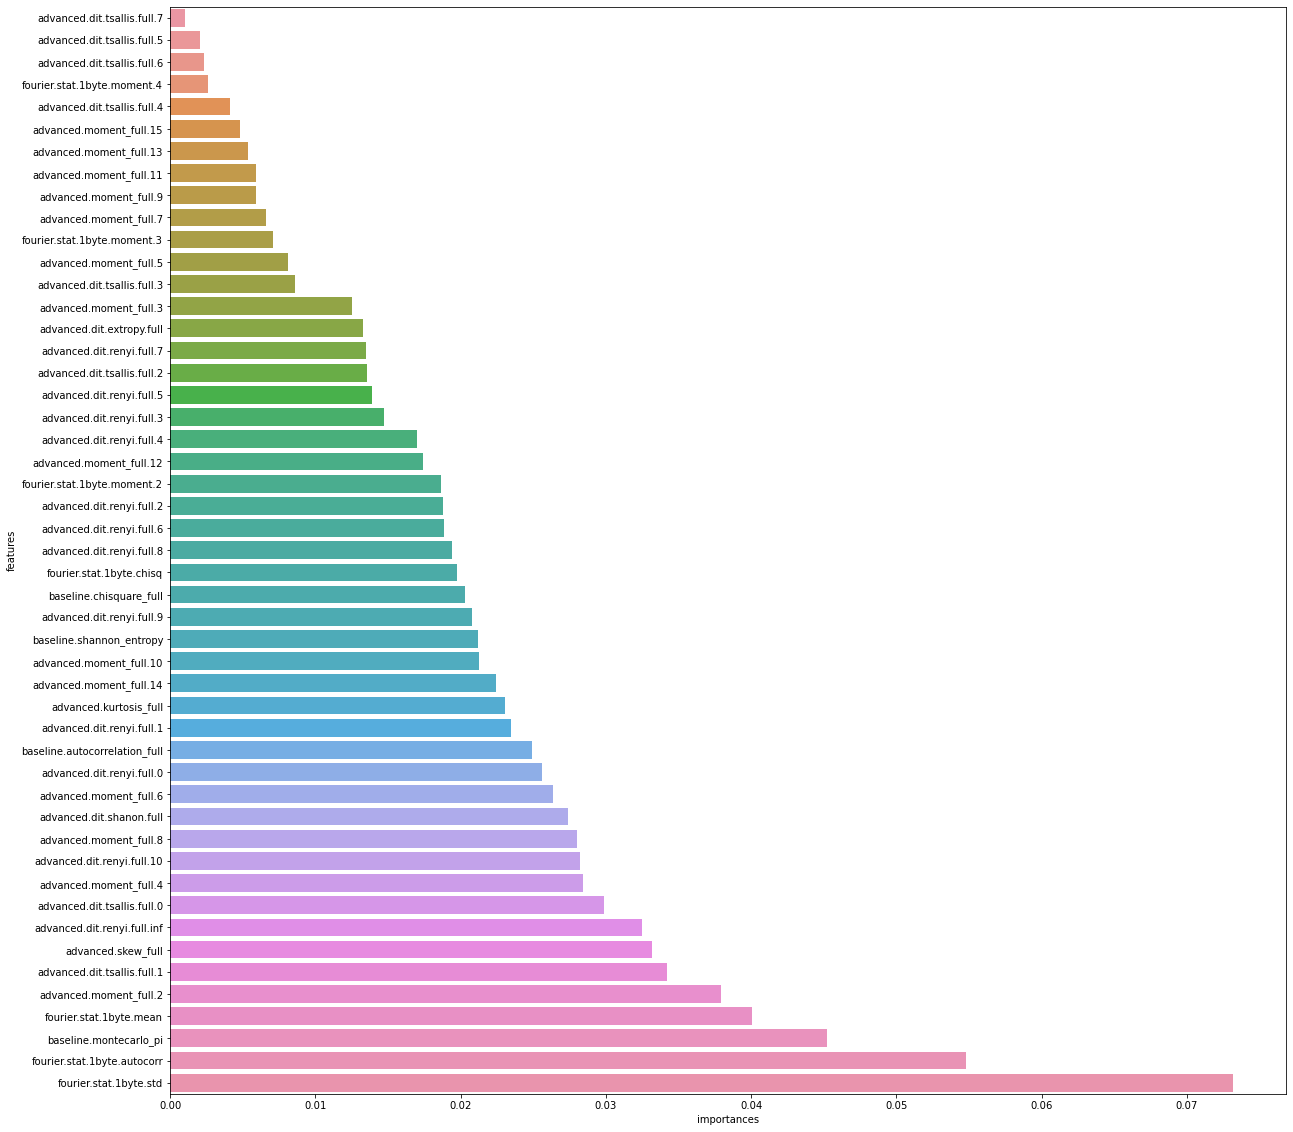

In [14]:
df2_dict = {"features": columns, "importances": get_weighted_importances_1(all_results)}
imp_df = pd.DataFrame(df2_dict)
imp_df = imp_df.sort_values(by="importances", ascending=True).reset_index(drop="True")
imp_df = imp_df[imp_df["importances"] > 0.001]
sns.barplot(y="features", x="importances", data=imp_df)

### Simple average


In [16]:
# Redefining this
####
def get_weighted_feature_importances_inloop(f1_scores, feature_importances):
    """
    Redefined function
    
    Next find the weighted mean w.r.t. the f1-score
    """
    #print("updated value was called")
    out_importances = np.zeros(len(feature_importances[0]))
    for f1, importance in zip(f1_scores, feature_importances):
        # importance = importance / np.max(importance)
        # importance = importance * f1
        out_importances = out_importances + importance
    out_importances /= len(f1_scores)
    return out_importances

all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0] if "feature_importance" not in k}
for result in all_results:
    for k, v in result.items():
        if "feature_importances" not in k:
            df_dict[k].append(v)


def get_weighted_importances_1(all_results):
    f1_colname = None
    importance_colname = None
    for k in all_results[0]:
        if "f1_score" in k:
            f1_colname = k
        if "feature_importance" in k:
            importance_colname = k
    f1_scores = []
    importances = []
    print(f1_colname, importance_colname)
    for result in all_results:
        f1_scores.append(result[f1_colname])
        importances.append(result[importance_colname])
    
    out_importances = np.zeros(len(importances[0]))
    for f1, imp in zip(f1_scores, importances):
        out_importances = out_importances + imp
    out_importances = out_importances / len(f1_scores)
    
    return out_importances

print(get_weighted_importances_1(all_results))


plt.rcParams["figure.figsize"] = (20,20)

columns = get_columns(df[[c for c in df.columns if "is_encrypted" != c]])["fourier"]



100%|██████████████████████████████████████████████████| 256/256 [1:18:18<00:00, 18.35s/it]


fourier-f1_score fourier-feature_importances
[2.25273763e-02 1.75790462e-02 1.10637105e-03 1.48105815e-02
 4.94814650e-03 3.28876505e-02 8.42044741e-03 2.19502287e-03
 5.43893128e-02 1.95827674e-02 7.15427311e-02 2.10083189e-02
 7.09776222e-03 1.86778596e-02 5.86137845e-05 1.37710819e-02
 2.12509532e-02 3.98744030e-02 1.51058087e-04 1.74904640e-06
 2.34034763e-02 6.04652577e-03 2.83373990e-02 5.99261550e-03
 3.76570309e-02 2.45775948e-02 2.43454173e-03 4.11164858e-06
 4.47594991e-02 4.24272708e-06 5.00033827e-05 1.40767912e-02
 1.36651409e-02 2.50752769e-02 1.31512120e-02 1.87290230e-02
 3.38000598e-02 4.24170891e-07 5.50305144e-03 1.41304276e-05
 6.78643509e-03 6.34797284e-04 4.31681136e-03 5.29917716e-05
 2.22045235e-04 2.82538661e-02 8.78499781e-03 2.72695415e-02
 5.74861297e-04 2.11483376e-02 2.01337955e-02 1.89321794e-02
 2.68179389e-03 3.92056393e-07 2.86553600e-02 1.33877199e-02
 2.78004004e-02 3.33502619e-02 2.62373092e-02 1.70051593e-02
 2.12598108e-02 9.33684923e-05 2.3254360

In [17]:
save_results("simple-average.pickle", columns, all_results)

fourier-f1_score fourier-feature_importances


<AxesSubplot:xlabel='importances', ylabel='features'>

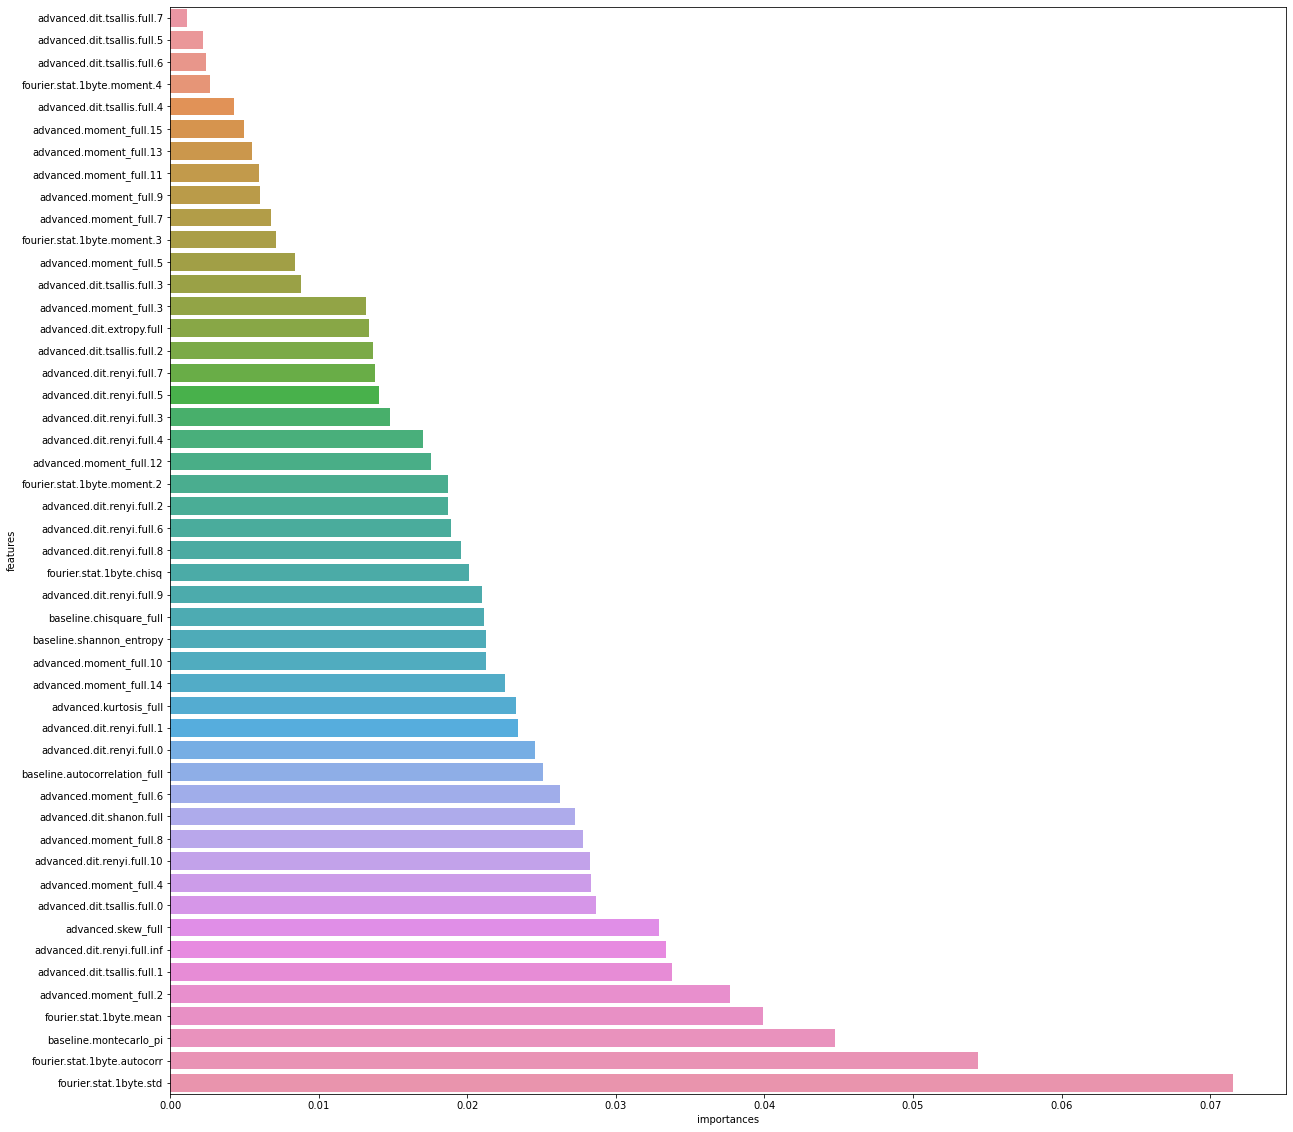

In [18]:
df2_dict = {"features": columns, "importances": get_weighted_importances_1(all_results)}
imp_df = pd.DataFrame(df2_dict)
imp_df = imp_df.sort_values(by="importances", ascending=True).reset_index(drop="True")
imp_df = imp_df[imp_df["importances"] > 0.001]
sns.barplot(y="features", x="importances", data=imp_df)